Loading 20 Newsgroups dataset...
Training Start: Topics=10, Vocab=1000
Epoch 10/50, Loss: 5.7609
Epoch 20/50, Loss: 5.7204
Epoch 30/50, Loss: 5.7076
Epoch 40/50, Loss: 5.7002
Epoch 50/50, Loss: 5.6958


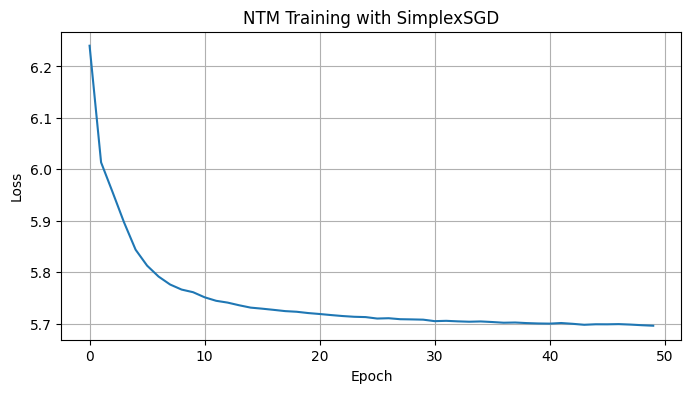


--- Learned Topics (Top words) ---
Topic 1: know, don, does, right, say, want, question, god, called, said
Topic 2: did, year, years, heard, team, let, ago, article, news, israel
Topic 3: probably, case, possible, power, place, problems, bike, wouldn, believe, source
Topic 4: use, problem, windows, file, program, available, help, space, stuff, version
Topic 5: used, com, better, set, line, using, window, work, code, control
Topic 6: people, read, course, true, wrong, yes, quite, fact, different, law
Topic 7: post, list, 10, ll, 20, 00, phone, 50, 30, net
Topic 8: like, edu, time, got, way, tell, game, actually, look, didn
Topic 9: just, think, good, ve, make, really, sure, doesn, car, thing
Topic 10: thanks, mail, looking, drive, hi, new, card, email, interested, send


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# --- Configuration ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float64 # 数値安定性のため倍精度推奨
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer: Explicit Euclidean Gradient on Simplex (Matrix Support) ---
class SimplexSGD(optim.Optimizer):
    """
    期待値パラメータのユークリッド勾配を利用した簡易版自然勾配法。
    行列パラメータに対応 (dim引数でSimplexの軸を指定)。
    
    Args:
        params: 最適化するパラメータ
        lr: 学習率 (推奨 < 0.1)
        dim: Softmaxをとる次元 (トピック分布の場合は通常 1)
    """
    def __init__(self, params, lr=0.01, dim=1):
        defaults = dict(lr=lr, dim=dim)
        super(SimplexSGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            dim = group['dim']
            lr = group['lr']
            
            for p in group['params']:
                if p.grad is None: continue

                # 1. 期待値パラメータ w (確率分布) の計算
                w = torch.softmax(p, dim=dim)
                
                # 2. 自然パラメータの勾配 (dL/dtheta)
                d_theta = p.grad
                
                # 3. 期待値パラメータのユークリッド勾配 (dL/dw) を復元
                # dL/dw = dL/dtheta / w
                eps = 1e-12
                d_w = d_theta / (w + eps)
                
                # 4. ドリフト防止の中心化 (Mean Subtraction along dim)
                # 行列の各行(トピック)ごとに平均を引く
                d_w_mean = d_w.mean(dim=dim, keepdim=True)
                d_w_centered = d_w - d_w_mean
                
                # 5. 更新 (自然勾配方向へ進む)
                p.sub_(lr * d_w_centered)
                
        return loss

# --- 2. Neural Topic Model (Autoencoder Style) ---
class NeuralTopicModel(nn.Module):
    def __init__(self, vocab_size, n_topics, hidden_dim=100):
        super(NeuralTopicModel, self).__init__()
        self.vocab_size = vocab_size
        self.n_topics = n_topics
        
        # Encoder: 文書(BoW) -> トピック混合比(theta)
        # ここは通常のNNなのでReLUなどを使う
        self.encoder = nn.Sequential(
            nn.Linear(vocab_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, n_topics),
            nn.BatchNorm1d(n_topics), # NTMではBNが重要
            nn.Softmax(dim=1)         # 文書ごとのトピック分布 theta
        )
        
        # Decoder: トピック(theta) -> 文書再構成
        # self.topic_word_logits は [n_topics, vocab_size] の行列
        # 各行が1つのトピック（単語分布）を表す
        self.topic_word_logits = nn.Parameter(torch.randn(n_topics, vocab_size))

    def get_topics(self):
        # トピック-単語分布 beta (Softmaxで確率化)
        return torch.softmax(self.topic_word_logits, dim=1)

    def forward(self, x):
        # 1. Encode
        theta = self.encoder(x) # [batch, n_topics]
        
        # 2. Decode
        beta = self.get_topics() # [n_topics, vocab]
        
        # 文書ごとの単語生成確率: recon = theta @ beta
        recon = torch.mm(theta, beta) # [batch, vocab]
        
        # 数値安定性のため log をとって返す
        return torch.log(recon + 1e-10), theta

# --- 3. Data Preparation (20 Newsgroups) ---
def load_data(max_features=1000):
    print("Loading 20 Newsgroups dataset...")
    dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(dataset.data)
    feature_names = vectorizer.get_feature_names_out()
    
    # データをPyTorch Tensorに変換 (正規化されたBoW)
    X_dense = X.toarray()
    X_tensor = torch.tensor(X_dense, dtype=DTYPE)
    # 入力は確率分布として扱うため、文書ごとに合計1になるよう正規化
    X_tensor = X_tensor / (X_tensor.sum(dim=1, keepdim=True) + 1e-10)
    
    return X_tensor, feature_names

# --- 4. Training Loop ---
def train_ntm(X_train, feature_names, n_topics=10, n_epochs=50, batch_size=64):
    vocab_size = X_train.shape[1]
    model = NeuralTopicModel(vocab_size, n_topics).to(device)
    X_train = X_train.to(device)
    
    # --- Optimizer Assignment ---
    # 1. Encoder (通常の重み) -> Adam
    optimizer_enc = optim.Adam(model.encoder.parameters(), lr=0.002)
    
    # 2. Decoder (トピック分布) -> SimplexSGD (今回の主役)
    # トピック行列は「確率単体」なので、ここで自然勾配を使う
    optimizer_dec = SimplexSGD([model.topic_word_logits], lr=0.1, dim=1)
    
    print(f"Training Start: Topics={n_topics}, Vocab={vocab_size}")
    loss_history = []
    
    for epoch in range(n_epochs):
        perm = torch.randperm(X_train.size(0))
        epoch_loss = 0
        
        for i in range(0, X_train.size(0), batch_size):
            indices = perm[i:i+batch_size]
            batch_x = X_train[indices]
            
            # Forward
            log_recon, theta = model(batch_x)
            
            # Loss: Reconstruction Loss (Cross Entropy)
            # Minimize -sum(x * log(recon))
            loss = -(batch_x * log_recon).sum(dim=1).mean()
            
            # Update
            optimizer_enc.zero_grad()
            optimizer_dec.zero_grad()
            loss.backward()
            
            optimizer_enc.step() # Encoder更新
            optimizer_dec.step() # Decoder更新 (SimplexSGD)
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / (X_train.size(0) / batch_size)
        loss_history.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

    return model, loss_history

# --- 5. Visualization & Inspection ---
def show_topics(model, feature_names, top_n=10):
    topics = model.get_topics().detach().cpu().numpy()
    
    print("\n--- Learned Topics (Top words) ---")
    for i, topic_dist in enumerate(topics):
        top_indices = topic_dist.argsort()[:-top_n - 1:-1]
        top_words = [feature_names[j] for j in top_indices]
        # トピックのスパース性確認のため、トップ単語の確率値を表示
        top_probs = [f"{topic_dist[j]:.2f}" for j in top_indices]
        
        print(f"Topic {i+1}: {', '.join(top_words)}")
        # print(f"Probs: {top_probs}") # 確率値を見たい場合はコメントアウト解除

def run_experiment():
    # データ読み込み (軽量化のため語彙数1000に制限)
    X, vocab = load_data(max_features=1000)
    
    # 学習
    model, losses = train_ntm(X, vocab, n_topics=10, n_epochs=50)
    
    # 学習曲線の表示
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label='Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('NTM Training with SimplexSGD')
    plt.grid(True)
    plt.show()
    
    # 獲得されたトピックの表示
    show_topics(model, vocab)

if __name__ == "__main__":
    run_experiment()

Iter | KL Divergence | Max Weight
-----------------------------------
   0 | 0.112590    | 0.0133
  10 | 0.001178    | 0.0394
  20 | 0.000432    | 0.0460
  30 | 0.000227    | 0.0494
  40 | 0.000133    | 0.0514
  50 | 0.000087    | 0.0527
  60 | 0.000062    | 0.0536
  70 | 0.000049    | 0.0542
  80 | 0.000041    | 0.0547
  90 | 0.000036    | 0.0550
 100 | 0.000033    | 0.0553
 110 | 0.000032    | 0.0555
 120 | 0.000030    | 0.0557
 130 | 0.000029    | 0.0558
 140 | 0.000029    | 0.0560
 150 | 0.000028    | 0.0561
-----------------------------------
Final KL Divergence: 0.000028
Paper's Typical Range: 0.009 - 0.035 


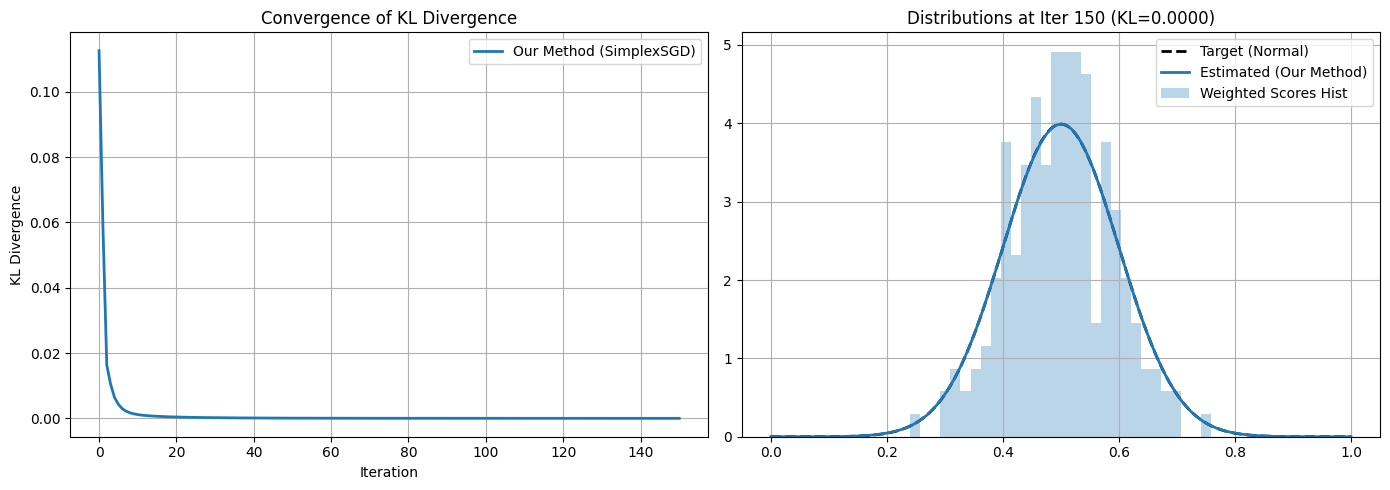

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Optimizer: Our Method (Explicit Euclidean Gradient on Simplex) ---
class SimplexSGD(optim.Optimizer):
    """
    期待値パラメータのユークリッド勾配を明示的に利用するオプティマイザ。
    (論文のCauchy-Simplexと考え方は近いが、Line Searchなしで高速に動作する設計)
    """
    def __init__(self, params, lr=0.1):
        defaults = dict(lr=lr)
        super(SimplexSGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None: continue
                
                # w (Expectation Param)
                w = torch.softmax(p, dim=0)
                
                # dL/dtheta
                d_theta = p.grad
                
                # dL/dw = dL/dtheta / w (Explicit Euclidean Gradient)
                eps = 1e-12
                d_w = d_theta / (w + eps)
                
                # Center the gradient (remove drift in theta space)
                d_w = d_w - d_w.mean()
                
                # Update: Move in the direction of negative natural gradient
                p.sub_(lr * d_w)
                
        return loss

# --- 2. Data Generation (According to Paper Sec 6.2) ---
def generate_exam_data(n_students=200, n_questions=75):
    # Difficulty q_i [cite: 413]
    q = torch.zeros(n_questions)
    q[:60] = 7/8  # Easy
    q[60:] = 1/5  # Hard
    
    # Smartness s_j [cite: 413]
    s = torch.zeros(n_students)
    s[:120] = 7/10 # Smart
    s[120:] = 1/2  # Average
    
    # Probability Matrix P_ij = q_i * s_j
    # Bernoulli sampling [cite: 412]
    probs = torch.outer(q, s)
    X = torch.bernoulli(probs) # [n_questions, n_students]
    
    return X

# --- 3. Model & Loss (KDE & KL Divergence) ---
class ExamWeightingModel(nn.Module):
    def __init__(self, n_questions):
        super().__init__()
        # Initial weights: Uniform (1/n) [cite: 479]
        # We store as theta (logits) initialized to zeros
        self.theta = nn.Parameter(torch.zeros(n_questions))
        
    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)

def gaussian_kde(samples, grid, bandwidth=0.05):
    """
    Differentiable Kernel Density Estimation
    rho_epsilon(z) [cite: 392, 394]
    """
    # samples: [n_students]
    # grid: [n_grid_points]
    n = samples.shape[0]
    
    # (x - X_j) / epsilon
    diff = (grid.unsqueeze(1) - samples.unsqueeze(0)) / bandwidth
    
    # Standard Normal PDF
    pdf = torch.exp(-0.5 * diff**2) / np.sqrt(2 * np.pi)
    
    # Average over samples and divide by bandwidth
    density = pdf.sum(dim=1) / (n * bandwidth)
    return density

def target_distribution(grid):
    """
    Target f: Truncated Normal (mean=0.5, std=0.1) [cite: 416]
    """
    mu = 0.5
    sigma = 0.1
    pdf = torch.exp(-0.5 * ((grid - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    
    # Simple truncation/normalization over the grid [0, 1]
    pdf = pdf / pdf.sum() # Normalize to sum to 1 on the grid for KL calculation
    return pdf

def riemann_kl_divergence(p, q, dx):
    """
    Riemann approximation of KL Divergence [cite: 400]
    sum p * log(p/q) * dx
    """
    # Numerical stability
    p = p + 1e-12
    q = q + 1e-12
    
    # Normalize densities to valid PMFs on the grid for correct KL calculation
    p = p / (p.sum() * dx)
    q = q / (q.sum() * dx)
    
    return (p * torch.log(p / q)).sum() * dx

# --- 4. Main Experiment ---
def run_comparison():
    # Setup
    n_students = 200
    n_questions = 75
    X = generate_exam_data(n_students, n_questions)
    
    model = ExamWeightingModel(n_questions)
    
    # Optimizer: Our Method
    # Paper uses line search. We use fixed LR.
    # User suggestion: LR < 0.1. Let's try 0.05.
    optimizer = SimplexSGD(model.parameters(), lr=1)
    
    # Grid for Riemann Sum [0, 1] with 400 steps [cite: 417]
    grid = torch.linspace(0, 1, 401)
    dx = 1.0 / 400
    target_pdf = target_distribution(grid)
    
    loss_history = []
    
    print("Iter | KL Divergence | Max Weight")
    print("-" * 35)
    
    # Loop for 150 iterations (Same as Paper [cite: 418])
    for i in range(151):
        optimizer.zero_grad()
        
        # 1. Calculate Weighted Scores X_j [cite: 390]
        # weights: [n_questions], X: [n_questions, n_students]
        w = model.weights
        student_scores = torch.matmul(w, X)
        
        # 2. KDE [cite: 392]
        estimated_pdf = gaussian_kde(student_scores, grid, bandwidth=0.05)
        
        # 3. Loss (KL) [cite: 400]
        loss = riemann_kl_divergence(estimated_pdf, target_pdf, dx)
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if i % 10 == 0 or i == 150:
            print(f"{i:4d} | {loss.item():.6f}    | {w.max().item():.4f}")

    # --- Analysis & Visualization ---
    
    # Paper Table 2 Comparison:
    # Best methods (PFW) achieved ~0.009 - 0.030 range.
    final_loss = loss_history[-1]
    print("-" * 35)
    print(f"Final KL Divergence: {final_loss:.6f}")
    print(f"Paper's Typical Range: 0.009 - 0.035 ")
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Loss Curve
    ax1.plot(loss_history, label='Our Method (SimplexSGD)', linewidth=2)
    ax1.set_title('Convergence of KL Divergence')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('KL Divergence')
    ax1.grid(True)
    ax1.legend()
    
    # 2. Final Distributions
    with torch.no_grad():
        final_scores = torch.matmul(model.weights, X)
        final_pdf = gaussian_kde(final_scores, grid, bandwidth=0.05)
        
        # Normalize for plotting
        target_plot = target_pdf / (target_pdf.sum() * dx)
        final_plot = final_pdf / (final_pdf.sum() * dx)

    ax2.plot(grid.numpy(), target_plot.numpy(), label='Target (Normal)', linestyle='--', linewidth=2, color='black')
    ax2.plot(grid.numpy(), final_plot.numpy(), label='Estimated (Our Method)', linewidth=2, color='tab:blue')
    ax2.hist(final_scores.numpy(), bins=30, density=True, alpha=0.3, color='tab:blue', label='Weighted Scores Hist')
    ax2.set_title(f'Distributions at Iter 150 (KL={final_loss:.4f})')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_comparison()